In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS = Path( "data/model") 
DATA = Path( "data") 

In [2]:
# load performance data (provided by TE publication)
raw_ert = pd.read_csv(DATA / "raw_ert.csv")
rel_ert = pd.read_csv(DATA / "rel_ert.csv")
# load ELA data, TE features from TE publication and SH features calculated in "00_calculate_ela_features.py"
# combined in "01_combine_TE_and_SH_ela_feature_data.R"
ela = pd.read_csv(DATA / "ela_data_combined.csv")
# produced by "02_train_model.py"
# results of models trained on TE and SH
aas_predictions_te_sh = pd.read_csv(RESULTS / "final_rf_42_aas_prediction.csv")

In [3]:
# split in two seperate data frames one per feature encoding
aas_predictions_te_sh['encoding'] = 'HB-' + aas_predictions_te_sh['encoding'].astype(str)

aas_predictions_te = aas_predictions_te_sh.query("encoding == 'HB-TE'").reset_index(drop=True).sort_values(by=["bench", "dim", "instance", "rep",]).reset_index(drop=True)
aas_predictions_sh = aas_predictions_te_sh.query("encoding == 'HB-SH'").reset_index(drop=True).sort_values(by=["bench", "dim", "instance", "rep",]).reset_index(drop=True)

# is order equal ?
equal_order = (aas_predictions_sh.set_index(["bench", "dim", "instance", "rep"]).index == aas_predictions_te.set_index(["bench", "dim", "instance", "rep"]).index).sum()
if equal_order == 14040:
    print("Order of both sub-dataframes matches.")
else:
    print(equal_order)
    
# merge raw ert into dataframes
aas_predictions_te = pd.merge(aas_predictions_te.rename(columns={"ert":"rel_ert"}), raw_ert, how='left', on=['bench', 'instance', 'solver'])
aas_predictions_sh = pd.merge(aas_predictions_sh.rename(columns={"ert":"rel_ert"}), raw_ert, how='left', on=['bench', 'instance', 'solver'])

Order of both sub-dataframes matches.


In [4]:
# construct training labels for meta model when to pick SH and TE encoding for instances where the predictions differ
unequal_solver_predictions = ~(aas_predictions_sh.solver == aas_predictions_te.solver)
#differing_preds = aas_predictions_sh[unequal_solver_predictions].set_index(["bench", "dim", "instance", "rep",])
#pred_ert = pred_ert.set_index(["bench", "dim", "instance", "rep",])
#pred_ert.index.intersection(differing_preds.index)
te_wins = aas_predictions_sh[unequal_solver_predictions].ert > aas_predictions_te[unequal_solver_predictions].ert
labels = ['HB-TE' if te_win else 'HB-SH' for te_win in te_wins]
my_meta_labels = aas_predictions_sh[["bench", "dim", "instance", "rep"]][unequal_solver_predictions].reset_index(drop=True)
my_meta_labels["label"] = labels
my_meta_labels.to_csv(DATA / "my_meta_model_labels.csv")

In [5]:
# load meta model predictions (generated by "03_train_meta_model.py")
my_meta_model_prediction = pd.read_csv(RESULTS / "my_meta_model_prediction.csv")
meta_merged = pd.merge(my_meta_labels, my_meta_model_prediction, on=["bench", "dim", "instance", "rep"])
(meta_merged.label == meta_merged.solver).mean()
# accuracy on differing instances (without instances with matching predictions for TE and SH encoding)

0.6454918032786885

In [6]:
# this means we have only 229 of 702 for which in some repetitions not the same solver won every time
my_meta_labels[["bench", "instance"]].value_counts()

bench         instance
rbv2_svm      40981       14
rbv2_aknn     24          14
rbv2_glmnet   40966       13
rbv2_xgboost  41161       13
rbv2_glmnet   14          13
                          ..
rbv2_rpart    41143        1
rbv2_svm      40983        1
rbv2_rpart    40981        1
rbv2_svm      151          1
rbv2_glmnet   44           1
Length: 229, dtype: int64

In [7]:
#scenarios (dim = # of hyperparameters of the respective learner)
aas_predictions_sh[["bench", "dim"]].drop_duplicates()

,bench,dim
0,iaml_ranger,8
80,iaml_xgboost,13
160,rbv2_aknn,6
2520,rbv2_glmnet,3
4820,rbv2_ranger,8
7200,rbv2_rpart,5
9540,rbv2_svm,6
11660,rbv2_xgboost,14


In [8]:
#SBS
raw_ert.set_index(["bench", "instance"]).groupby("solver").mean()

,ert
solver,
EA,38897.839601
OP,96309.499074
RS,100674.436111
SM,13114.710755


In [9]:
#VBS
raw_ert.groupby(["bench", "instance"]).min().mean(numeric_only=True)

ert    444.328989
dtype: float64

In [10]:
#SBS
rel_ert.rename(columns={"ert":"rel_ert"}).set_index(["bench", "instance"]).groupby("solver").mean()

,rel_ert
solver,
EA,232.684864
OP,401.506247
RS,200.918346
SM,169.193882


In [11]:
#VBS
rel_ert.rename(columns={"ert":"rel_ert"}).groupby(["bench", "instance"]).min().mean(numeric_only=True)

rel_ert    1.0
dtype: float64

In [12]:
# SHAPELY ENCODING rel ert mean
aas_predictions_sh.set_index(["bench", "instance"]).rel_ert.mean()

18.15779189601612

In [13]:
# SHAPELY ENCODING raw ert mean
aas_predictions_sh.set_index(["bench", "instance"]).ert.mean()

3535.7150890313387

In [14]:
# TARGET ENCODING rel ert mean
aas_predictions_te.set_index(["bench", "instance"]).rel_ert.mean()

17.884535662383282

In [15]:
# TARGET ENCODING raw ert mean
aas_predictions_te.set_index(["bench", "instance"]).ert.mean()

3510.0310505698003

In [16]:
# helper function to add ert values to meta model prediction data frame
def ERT_query(bench, dim, instance, rep, solver, rel=False):
    if rel:
        if solver == 'HB-TE':
            return aas_predictions_te.query(f"bench == '{bench}'").query(f"dim == {dim}").query(f"instance == {instance}").query(f"rep == {rep}").rel_ert.values[0]
        else:
            return aas_predictions_sh.query(f"bench == '{bench}'").query(f"dim == {dim}").query(f"instance == {instance}").query(f"rep == {rep}").rel_ert.values[0]
    else:
        if solver == 'HB-TE':
            return aas_predictions_te.query(f"bench == '{bench}'").query(f"dim == {dim}").query(f"instance == {instance}").query(f"rep == {rep}").ert.values[0]
        else:
            return aas_predictions_sh.query(f"bench == '{bench}'").query(f"dim == {dim}").query(f"instance == {instance}").query(f"rep == {rep}").ert.values[0]

In [17]:
# add ert values to meta model prediction data frame
my_meta_model_prediction["ert"] = [ERT_query(*row[1].iloc[0:5].to_list()) for row in my_meta_model_prediction.iterrows()]
my_meta_model_prediction["rel_ert"] = [ERT_query(*row[1].iloc[0:5].to_list(), rel=True) for row in my_meta_model_prediction.iterrows()]

In [18]:
# grab all functions with matching predictions of SH and TE model
t = my_meta_model_prediction.set_index(["bench", "dim", "instance", "rep"]).index
t = ~aas_predictions_sh.set_index(["bench", "dim", "instance", "rep"]).index.isin(t)
noi_instances = aas_predictions_sh.set_index(["bench", "dim", "instance", "rep"])[t]

In [19]:
noi_instances

solver  rel_ert encoding model     ert
bench        dim instance rep                                       
iaml_ranger  8   1067     0       SM      1.0    HB-SH    rf  714.60
                          1       SM      1.0    HB-SH    rf  714.60
                          2       SM      1.0    HB-SH    rf  714.60
                          3       SM      1.0    HB-SH    rf  714.60
                          4       SM      1.0    HB-SH    rf  714.60
...                              ...      ...      ...   ...     ...
rbv2_xgboost 14  41278    13      SM      1.0    HB-SH    rf    8.65
                          14      SM      1.0    HB-SH    rf    8.65
                          16      SM      1.0    HB-SH    rf    8.65
                          17      SM      1.0    HB-SH    rf    8.65
                          18      SM      1.0    HB-SH    rf    8.65

[13064 rows x 5 columns]

In [20]:
# merge META MODEL raw ert
pd.concat([noi_instances.reset_index()[["bench", "ert"]], my_meta_model_prediction[["bench", "ert"]]]).mean(numeric_only=True)

ert    3118.572215
dtype: float64

In [21]:
# merge META MODEL rel_ert
pd.concat([noi_instances.rel_ert, my_meta_model_prediction.rel_ert]).mean()

16.177265485003367

In [22]:
# META MODEL raw ert per learner
pd.concat([noi_instances.reset_index()[["bench", "ert"]], my_meta_model_prediction[["bench", "ert"]]]).groupby("bench").mean()

,ert
bench,
iaml_ranger,30518.296875
iaml_xgboost,1170.400000
rbv2_aknn,1114.119894
rbv2_glmnet,8661.818761
rbv2_ranger,586.306408
rbv2_rpart,759.861474
rbv2_svm,4235.250071
rbv2_xgboost,2750.393613


In [23]:
# META MODEL rel ert per learner
pd.concat([noi_instances.reset_index()[["bench", "rel_ert"]], my_meta_model_prediction[["bench", "rel_ert"]]]).groupby("bench").mean()

,rel_ert
bench,
iaml_ranger,40.634628
iaml_xgboost,1.000000
rbv2_aknn,2.324887
rbv2_glmnet,45.345425
rbv2_ranger,1.004360
rbv2_rpart,1.755658
rbv2_svm,14.392969
rbv2_xgboost,32.355090


In [24]:
# Hybrid raw ERT
pd.DataFrame([aas_predictions_sh.ert, aas_predictions_te.ert]).T.min(axis=1).mean()

2209.2175427350426

In [25]:
# Hybrid rel ERT
pd.DataFrame([aas_predictions_sh.rel_ert, aas_predictions_te.rel_ert]).T.min(axis=1).mean()

10.821860323946318

# Confidence

In [26]:
# load confidence predictions generated by "05_train_model_mlp.py"
confidence = pd.read_csv(RESULTS / "final_RFHB_42_aas_prediction.csv")

In [27]:
confidence
# some weird value is saved in the "dim" column...

,bench,dim,instance,rep,solver_te,prob_te,solver_sh,prob_sh,solver,ert,encoding,model
0,rbv2_xgboost,1.000000,16,5,SM,0.98,SM,0.95,SM,1.0,SH,ML
1,rbv2_xgboost,1.000000,16,13,SM,0.99,SM,0.94,SM,1.0,SH,ML
2,rbv2_xgboost,1.000000,16,16,SM,0.93,SM,0.98,SM,1.0,SH,ML
3,rbv2_xgboost,1.000000,40923,12,OP,0.84,OP,0.72,OP,1.0,SH,ML
4,rbv2_xgboost,1.000000,41143,1,EA,0.83,EA,0.72,EA,1.0,SH,ML
...,...,...,...,...,...,...,...,...,...,...,...,...
14035,iaml_xgboost,0.909091,1489,9,SM,0.98,SM,0.98,SM,1.0,SH,ML
14036,iaml_xgboost,0.909091,1489,15,SM,0.96,SM,0.98,SM,1.0,SH,ML
14037,iaml_xgboost,0.909091,1067,0,SM,0.84,SM,0.87,SM,1.0,SH,ML
14038,iaml_xgboost,0.909091,1067,5,SM,0.90,SM,0.70,SM,1.0,SH,ML


In [28]:
te_wins = confidence.prob_te > confidence.prob_sh

In [29]:
confidence["merged_probs"] = confidence.apply(lambda r: r.prob_te if r.prob_te > r.prob_sh else r.prob_sh, axis=1)
confidence["merged_solvers"] = confidence.apply(lambda r: r.solver_te if r.prob_te > r.prob_sh else r.solver_sh, axis=1)


In [30]:
sdf_confidence = confidence[["bench", "dim", "instance", "rep", "merged_solvers"]].rename(columns={"merged_solvers":"solver"})
sdf_confidence = pd.merge(sdf_confidence, rel_ert, how="left", on=["bench", "instance", "solver"]).rename(columns={"ert":"rel_ert"})
sdf_confidence = pd.merge(sdf_confidence, raw_ert, how="left", on=["bench", "instance", "solver"])
sdf_confidence.groupby("bench")[["rel_ert", "ert"]].agg(["mean", "var", "count"], numeric_only=True)

rel_ert                                ert                    
                   mean            var count          mean           var count
bench                                                                         
iaml_ranger   45.919245    7572.153643    80  34499.463125  4.303906e+09    80
iaml_xgboost   1.000000       0.000000    80   1170.400000  2.367875e+03    80
rbv2_aknn      2.854299     382.724840  2360   1417.776123  1.263136e+08  2360
rbv2_glmnet   44.898966   33820.704621  2300   9309.983978  4.645119e+08  2300
rbv2_ranger    1.004948       0.001195  2380    586.502101  3.001692e+04  2380
rbv2_rpart     2.204810     251.247193  2340    971.749444  5.481261e+07  2340
rbv2_svm      10.474092    8598.960266  2120   3725.339528  3.940063e+08  2120
rbv2_xgboost  26.302100  348003.692983  2380   2631.570819  5.212613e+08  2380

In [31]:
sdf_confidence[["rel_ert", "ert"]].agg(["mean", "var"], numeric_only=True)

,rel_ert,ert
mean,14.680371,3.236690e+03
var,66219.541147,2.927862e+08


# Complete Meta Predictions

In [32]:
tmp_one = noi_instances.reset_index().drop(columns=["solver"])[['bench', 'dim', 'instance', 'rep',  'encoding', 'model','rel_ert',
       'ert']]
tmp_two = my_meta_model_prediction.rename(columns={"solver":"encoding",})[['bench', 'dim', 'instance', 'rep',  'encoding', 'model','rel_ert',
       'ert']]

In [33]:
complete_meta = pd.concat([tmp_one, tmp_two])

In [34]:
complete_meta.groupby("dim").var(numeric_only=True)

,instance,rep,rel_ert,ert
dim,,,,
3,3.468758e+08,33.264463,38190.946831,4.370194e+08
5,3.525384e+08,33.264215,156.746880,3.380416e+07
6,3.502480e+08,33.257424,9342.746213,2.634885e+08
8,3.603304e+08,33.263522,270.899158,1.541000e+08
13,4.007566e+08,33.670886,0.000000,2.367875e+03
14,3.580499e+08,33.263976,434756.308714,5.535788e+08


In [35]:
complete_meta.groupby("bench")[["rel_ert", "ert"]].agg(["mean", "var", "count"], numeric_only=True)

rel_ert                                ert                    
                   mean            var count          mean           var count
bench                                                                         
iaml_ranger   40.634628    6893.417182    80  30518.296875  3.917942e+09    80
iaml_xgboost   1.000000       0.000000    80   1170.400000  2.367875e+03    80
rbv2_aknn      2.324887     274.225244  2360   1114.119894  9.045793e+07  2360
rbv2_glmnet   45.345425   38190.946831  2300   8661.818761  4.370194e+08  2300
rbv2_ranger    1.004360       0.001021  2380    586.306408  2.997804e+04  2380
rbv2_rpart     1.755658     156.746880  2340    759.861474  3.380416e+07  2340
rbv2_svm      14.392969   19366.029179  2120   4235.250071  4.511070e+08  2120
rbv2_xgboost  32.355090  434756.308714  2380   2750.393613  5.535788e+08  2380

In [36]:
complete_meta[["rel_ert", "ert"]].agg(["mean", "var"], numeric_only=True)

,rel_ert,ert
mean,16.177265,3.118572e+03
var,83255.299587,2.885803e+08


# TE and SH

In [37]:
aas_predictions_sh.groupby("bench")[["rel_ert", "ert"]].agg(["mean", "count"], numeric_only=True)

rel_ert                 ert      
                   mean count          mean count
bench                                            
iaml_ranger   51.203862    80  38480.629375    80
iaml_xgboost   1.000000    80   1170.400000    80
rbv2_aknn      3.294416  2360   1671.022246  2360
rbv2_glmnet   47.052129  2300   8947.260522  2300
rbv2_ranger    1.006196  2380    586.663592  2380
rbv2_rpart     3.106802  2340   1397.594081  2340
rbv2_svm      15.798138  2120   4799.843585  2120
rbv2_xgboost  38.490612  2380   2985.188193  2380

In [38]:
aas_predictions_sh[["rel_ert", "ert"]].agg(["mean", "var"], numeric_only=True)

,rel_ert,ert
mean,18.157792,3.535715e+03
var,98537.082770,3.393115e+08


In [39]:
aas_predictions_te.groupby("bench")[["rel_ert", "ert"]].agg(["mean",  "count"], numeric_only=True)

rel_ert                 ert      
                   mean count          mean count
bench                                            
iaml_ranger   40.634628    80  30518.296875    80
iaml_xgboost   1.000000    80   1170.400000    80
rbv2_aknn      2.767932  2360   1367.143008  2360
rbv2_glmnet   50.898385  2300   9779.687522  2300
rbv2_ranger    1.004360  2380    586.306408  2380
rbv2_rpart     1.663636  2340    717.291624  2340
rbv2_svm      19.177784  2120   5248.906627  2120
rbv2_xgboost  32.449293  2380   2867.415000  2380

In [40]:
aas_predictions_te[["rel_ert", "ert"]].agg(["mean", "var"], numeric_only=True)

,rel_ert,ert
mean,17.884536,3.510031e+03
var,88227.405287,3.254746e+08


# Hybrid

In [41]:
aas_tmp = pd.merge(aas_predictions_sh, aas_predictions_te, how="left", on=['bench', 'dim', 'instance', 'rep',])

In [42]:
hybrid = (aas_tmp.assign(hybrid = lambda x: pd.DataFrame([x.ert_x, x.ert_y]).min())
.assign(hybrid_rel = lambda x: pd.DataFrame([x.rel_ert_x, x.rel_ert_y]).min()))

In [43]:
hybrid.groupby("bench")[["hybrid", "hybrid_rel"]].agg(["mean",  "count"], numeric_only=True)

hybrid       hybrid_rel      
                      mean count       mean count
bench                                            
iaml_ranger   28527.713750    80  37.992319    80
iaml_xgboost   1170.400000    80   1.000000    80
rbv2_aknn      1012.844894  2360   2.147282  2360
rbv2_glmnet    6685.961196  2300  29.077846  2300
rbv2_ranger     586.242353  2380   1.004099  2380
rbv2_rpart      588.030983  2340   1.385303  2340
rbv2_svm       1919.552052  2120   4.894405  2120
rbv2_xgboost   1694.470945  2380  25.573697  2380

In [44]:
hybrid[["hybrid", "hybrid_rel"]].agg(["mean", "var"], numeric_only=True)

,hybrid,hybrid_rel
mean,2.209218e+03,10.821860
var,1.748995e+08,62225.382156


# relERT for encoding baseline choices

the rel_ert.csv file contains the rel_ert calculated by division of all values on a row with the ERT of the VBS

Now we could make different choices for the VBS, e.g. use the results of the hybrid between SH and TE (lets call it VBE) as our overall VBS, the SBS/SBE would than be either TE encoding, we than report on closing the gap between SBE and VBE.

In [45]:
cols = ["bench", "dim", "instance", "rep", "ert"]

tmp_one = pd.merge(
    aas_predictions_te[cols], aas_predictions_sh[cols], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
).rename(columns={"ert_x":"TE", "ert_y":"SH"})

tmp_two = pd.merge(
    tmp_one, hybrid[["bench", "dim", "instance", "rep", "hybrid"]], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
)
tmp_three =pd.merge(
    tmp_two, complete_meta[cols], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
).rename(columns={"ert":"meta"})

all_raw_ert = pd.merge(tmp_three, sdf_confidence[cols],
         how="left",
         on=["bench", "instance", "rep"]
).drop(columns=["dim_y"]).rename(columns={"ert":"confidence"})




In [46]:
# divide all cols by the hybrid col to set it as VBS an create a new relERT
all_raw_ert.iloc[:,4:] = all_raw_ert.iloc[:,4:].div(all_raw_ert.hybrid, axis=0)

In [47]:
pd.options.display.float_format = "{:,.2f}".format
all_raw_ert.groupby("bench")[['TE', 'SH', 'hybrid', 'meta',
       'confidence']].agg("mean", numeric_only="True").assign(gap_closure = lambda x: ((x.confidence - x.hybrid)/(x.TE - x.hybrid)-1)*-100)

,TE,SH,hybrid,meta,confidence,gap_closure
bench,,,,,,
iaml_ranger,3.64,14.21,1.00,3.64,8.93,-200.00
iaml_xgboost,1.00,1.00,1.00,1.00,1.00,NaN
rbv2_aknn,1.62,2.15,1.00,1.18,1.71,-13.92
rbv2_glmnet,22.50,17.95,1.00,16.31,16.89,26.08
rbv2_ranger,1.00,1.00,1.00,1.00,1.00,-224.10
rbv2_rpart,1.28,2.72,1.00,1.37,1.82,-194.49
rbv2_svm,15.28,11.90,1.00,10.50,7.36,55.46
rbv2_xgboost,7.88,13.92,1.00,7.78,1.73,89.41


In [48]:
# relative gap closure
#for actual values comment out after .agg(...)
all_raw_ert[['TE', 'SH', 'hybrid', 'meta',
       'confidence']].agg(["mean"], numeric_only="True").sub(1).div(7.00878).sub(1).mul(-100)
#.assign(gap_closure = lambda x: ((x.confidence - x.hybrid)/(x.TE - x.hybrid)-1)*-100)

,TE,SH,hybrid,meta,confidence
mean,-0.00,-2.26,100.00,25.84,43.10


In [49]:
all_raw_ert

,bench,dim_x,instance,rep,TE,SH,hybrid,meta,confidence
0,iaml_ranger,8,1067,0,1.00,1.00,1.00,1.00,1.00
1,iaml_ranger,8,1067,1,1.00,1.00,1.00,1.00,1.00
2,iaml_ranger,8,1067,2,1.00,1.00,1.00,1.00,1.00
3,iaml_ranger,8,1067,3,1.00,1.00,1.00,1.00,1.00
4,iaml_ranger,8,1067,4,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
14035,rbv2_xgboost,14,41278,15,1.13,1.00,1.00,1.13,1.00
14036,rbv2_xgboost,14,41278,16,1.00,1.00,1.00,1.00,1.00
14037,rbv2_xgboost,14,41278,17,1.00,1.00,1.00,1.00,1.00
14038,rbv2_xgboost,14,41278,18,1.00,1.00,1.00,1.00,1.00


In [50]:
cols = ["bench", "dim", "instance", "rep", "rel_ert"]

tmp_one = pd.merge(
    aas_predictions_te[cols], aas_predictions_sh[cols], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
).rename(columns={"rel_ert_x":"TE", "rel_ert_y":"SH"})

tmp_two = pd.merge(
    tmp_one, hybrid[["bench", "dim", "instance", "rep", "hybrid_rel"]], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
)
tmp_three =pd.merge(
    tmp_two, complete_meta[cols], 
    how="left", 
    on=["bench", "dim", "instance", "rep"]
).rename(columns={"rel_ert":"meta"})

all_rel_ert = pd.merge(tmp_three, sdf_confidence[cols],
         how="left",
         on=["bench", "instance", "rep"]
).drop(columns=["dim_y"]).rename(columns={"rel_ert":"confidence"})




In [51]:
all_rel_ert

,bench,dim_x,instance,rep,TE,SH,hybrid_rel,meta,confidence
0,iaml_ranger,8,1067,0,1.00,1.00,1.00,1.00,1.00
1,iaml_ranger,8,1067,1,1.00,1.00,1.00,1.00,1.00
2,iaml_ranger,8,1067,2,1.00,1.00,1.00,1.00,1.00
3,iaml_ranger,8,1067,3,1.00,1.00,1.00,1.00,1.00
4,iaml_ranger,8,1067,4,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...
14035,rbv2_xgboost,14,41278,15,1.13,1.00,1.00,1.13,1.00
14036,rbv2_xgboost,14,41278,16,1.00,1.00,1.00,1.00,1.00
14037,rbv2_xgboost,14,41278,17,1.00,1.00,1.00,1.00,1.00
14038,rbv2_xgboost,14,41278,18,1.00,1.00,1.00,1.00,1.00


In [52]:
import matplotlib.pyplot as plt
plt.rcParams['axes.formatter.limits'] = (-10_000, 10_000)

In [53]:
SCENARIOS = ['rbv2_glmnet', 'rbv2_rpart', 'rbv2_aknn', 'rbv2_svm', 'iaml_ranger', 'rbv2_ranger', 'iaml_xgboost', 'rbv2_xgboost']

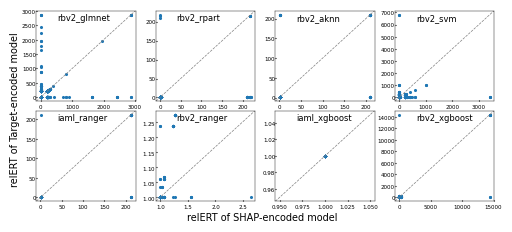

In [54]:
fig, ax = plt.subplots(2,4,figsize=[4.804,2])
axes = ax.ravel()
fontsize=4
for i, scenario in enumerate(SCENARIOS):
    data = all_rel_ert.query(f"bench == '{scenario}'")[["TE", "SH"]]
    X, Y = data.SH.values, data.TE.values
   
    
    axes[i].plot([0, 1], [0, 1], transform=axes[i].transAxes, linestyle="dashed", color="gray", linewidth=.5)
    #axes[i].hist2d(X,Y, bins=20)
    axes[i].scatter(X,Y, s=1.5)
    axes[i].tick_params('both', direction='in', labelsize=4, size=1, pad=0.2)
    axes[i].tick_params('x', direction='in', labelsize=fontsize, size=1, pad=2)
    axes[i].text(0.21,.89,scenario, transform=axes[i].transAxes, fontsize=6)
    for axis in ['top','bottom','left','right']:
        axes[i].spines[axis].set_linewidth(.3)
    

axes[5].ticklabel_format(axis='y',style='sci',scilimits=(1,4))
axes[5].yaxis.major.formatter._useMathText = True
fig.tight_layout(pad=0)
fig.supxlabel("relERT of SHAP-encoded model", fontsize=7, y=-0.065)
fig.supylabel("relERT of Target-encoded model", fontsize=7, x= -.025)
fig.savefig("SHvsTE.pdf",bbox_inches='tight')